# 1. 목표
> Telco Customer Churn 데이터 활용으로:

- 이탈 고객과 비이탈 고객의 특성을 비교   
- **이탈 위험 고객군을 식별**   
- **고객 유치 전략(예: 할인, 혜택 제공, 맞춤 마케팅)**의 기반 데이터로 활용

# 2. 순서
### 1) EDA (탐색적 데이터 분석)
- 결측치, 이상치 확인 및 처리    
- 이탈 여부(`Churn`) 비율 확인    
- 연속형 변수(예: `MonthlyCharges`, `TotalCharges`, `tenure`)에 따른 이탈 여부 분포 비교    
- 범주형 변수(예: `Contract`, `InternetService`, `PaymentMethod`)별 이탈률 시각화

### 2) 시각화
- `sns.countplot` / `sns.barplot` / `plt.hist` / `plt.boxplot`으로 이탈 여부별 변수 비교   
- Heatmap으로 변수 간 상관관계 확인

### 3) 고객군 식별 로직 설계
- 특정 조건(예: 단기 가입자, 월 요금 높은데 계약기간 짧음, 전자결제 사용, 월별 결제 등)으로 조건 필터링하여 이탈 위험 고객군 추출

### 4) 추가적으로 기술을 익히면 좋을 것
 - `RandomForest`, `LogisticRegression`, `XGBoost` 등을 사용해 이탈 예측 모델까지 확장 가능

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# 경고 안 뜨게 하기

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 파일 불러오기

df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [4]:

# 시스템 환경에 따라 폰트를 자동으로 설정해주는 함수
def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin":
        return "AppleGothic"
    elif system_name == "Windows":
        return "Malgun Gothic"
    else:
        # Linux (Colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        return "NanumBarunGothic"

# 한글 폰트 적용
plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

# 레티나 디스플레이 설정 (선명하게)
%config InlineBackend.figure_format = 'retina'



In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 1️⃣ 결측치 및 데이터 타입 확인 후 정제
- `isnull().sum()`, `info()`, `describe()` 확인   
- `TotalCharges` 문자열 → 숫자 변환   
- 결측값/공백 처리 및 타입 정리

In [7]:


#1️⃣ 데이터 타입 및 결측치 확인
df.info()

# 결측치 확인 (공백 포함)
missing_check = df.isnull().sum()

# TotalCharges의 공백을 NaN 처리 후 수치형(float)으로 변환(우선 공백 확인)

blank_totalcharges = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]

# TotalCharges를 수치형으로 변환, errors='coerce'로 공백을 NaN으로 처리
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 변환 후 결측치 재확인
missing_after_conversion = df.isnull().sum()

# 결측치 행 제거 후 데이터 클린 완료
df_clean = df.dropna()

# 결과 요약 확인
df_clean.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 설명:
- TotalCharges의 공백을 NaN 처리 후 수치형(float)으로 변환 완료     
- 결측치가 있던 11개의 행 제거 후 7032명 고객 데이터 정제 완료

## 2️⃣ Churn 비율 및 기본 통계 시각화
- 연속형
    - MonthlyCharges, TotalCharges, tenure → 분석 및 시각화 가능    
- 범주형
    - gender, Contract, PaymentMethod 등 → 시각화 및 그룹 분석 가능 


In [8]:
#2️⃣ Churn 비율 및 기본 통계 시각화

# Churn 비율 확인
churn_counts = df_clean['Churn'].value_counts()
churn_ratio = df_clean['Churn'].value_counts(normalize=True) * 100

# 1) 비율 텍스트 출력
print("Churn 비율(%)")
print(churn_ratio)




Churn 비율(%)
Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


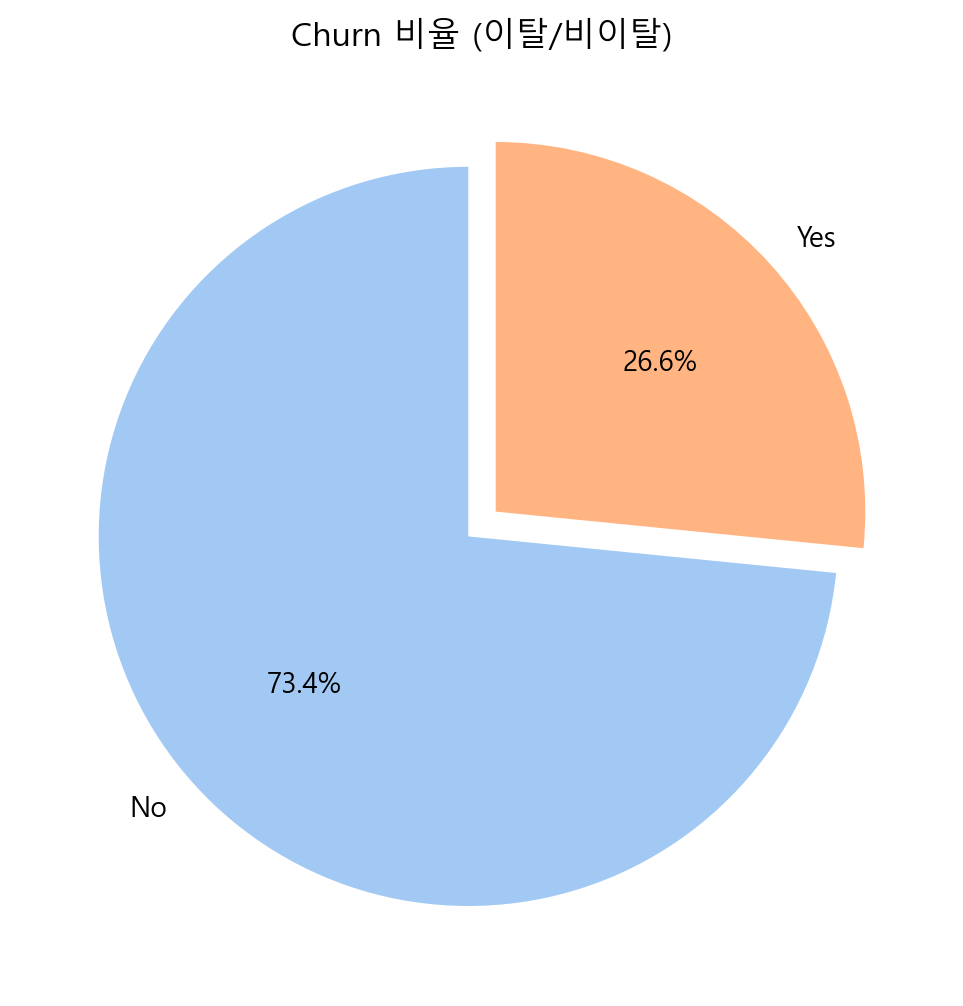

In [14]:
# 2) 파이 차트로 이탈/비이탈 비율 시각화
colors = ['#A1C9F4', '#FFB482']
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05),colors=colors)
plt.title('Churn 비율 (이탈/비이탈)')
plt.show()



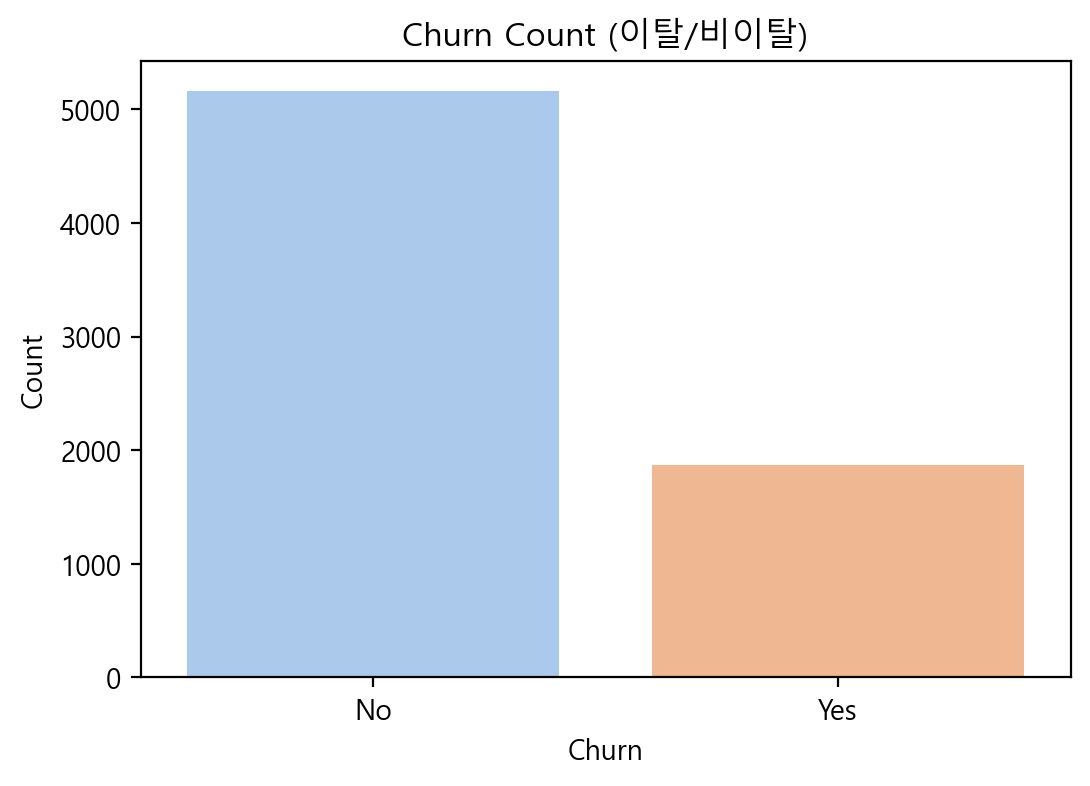

In [22]:
# 3) 카운트 플롯으로 시각화
plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='Churn', palette='pastel')
plt.title('Churn Count (이탈/비이탈)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

### 설명:
- 이탈(Churn: Yes) 비율: 26.6%   
- 비이탈(Churn: No) 비율: 73.4%   
즉, 약 4명 중 1명이 이탈하는 데이터 구조


## 3️⃣ 연속형 변수 vs Churn 관계 분석 (boxplot, histplot)
- **분석 대상**
    - `tenure` (가입 기간)
    - `MonthlyCharges` (월 요금)
    - `TotalCharges` (누적 요금)

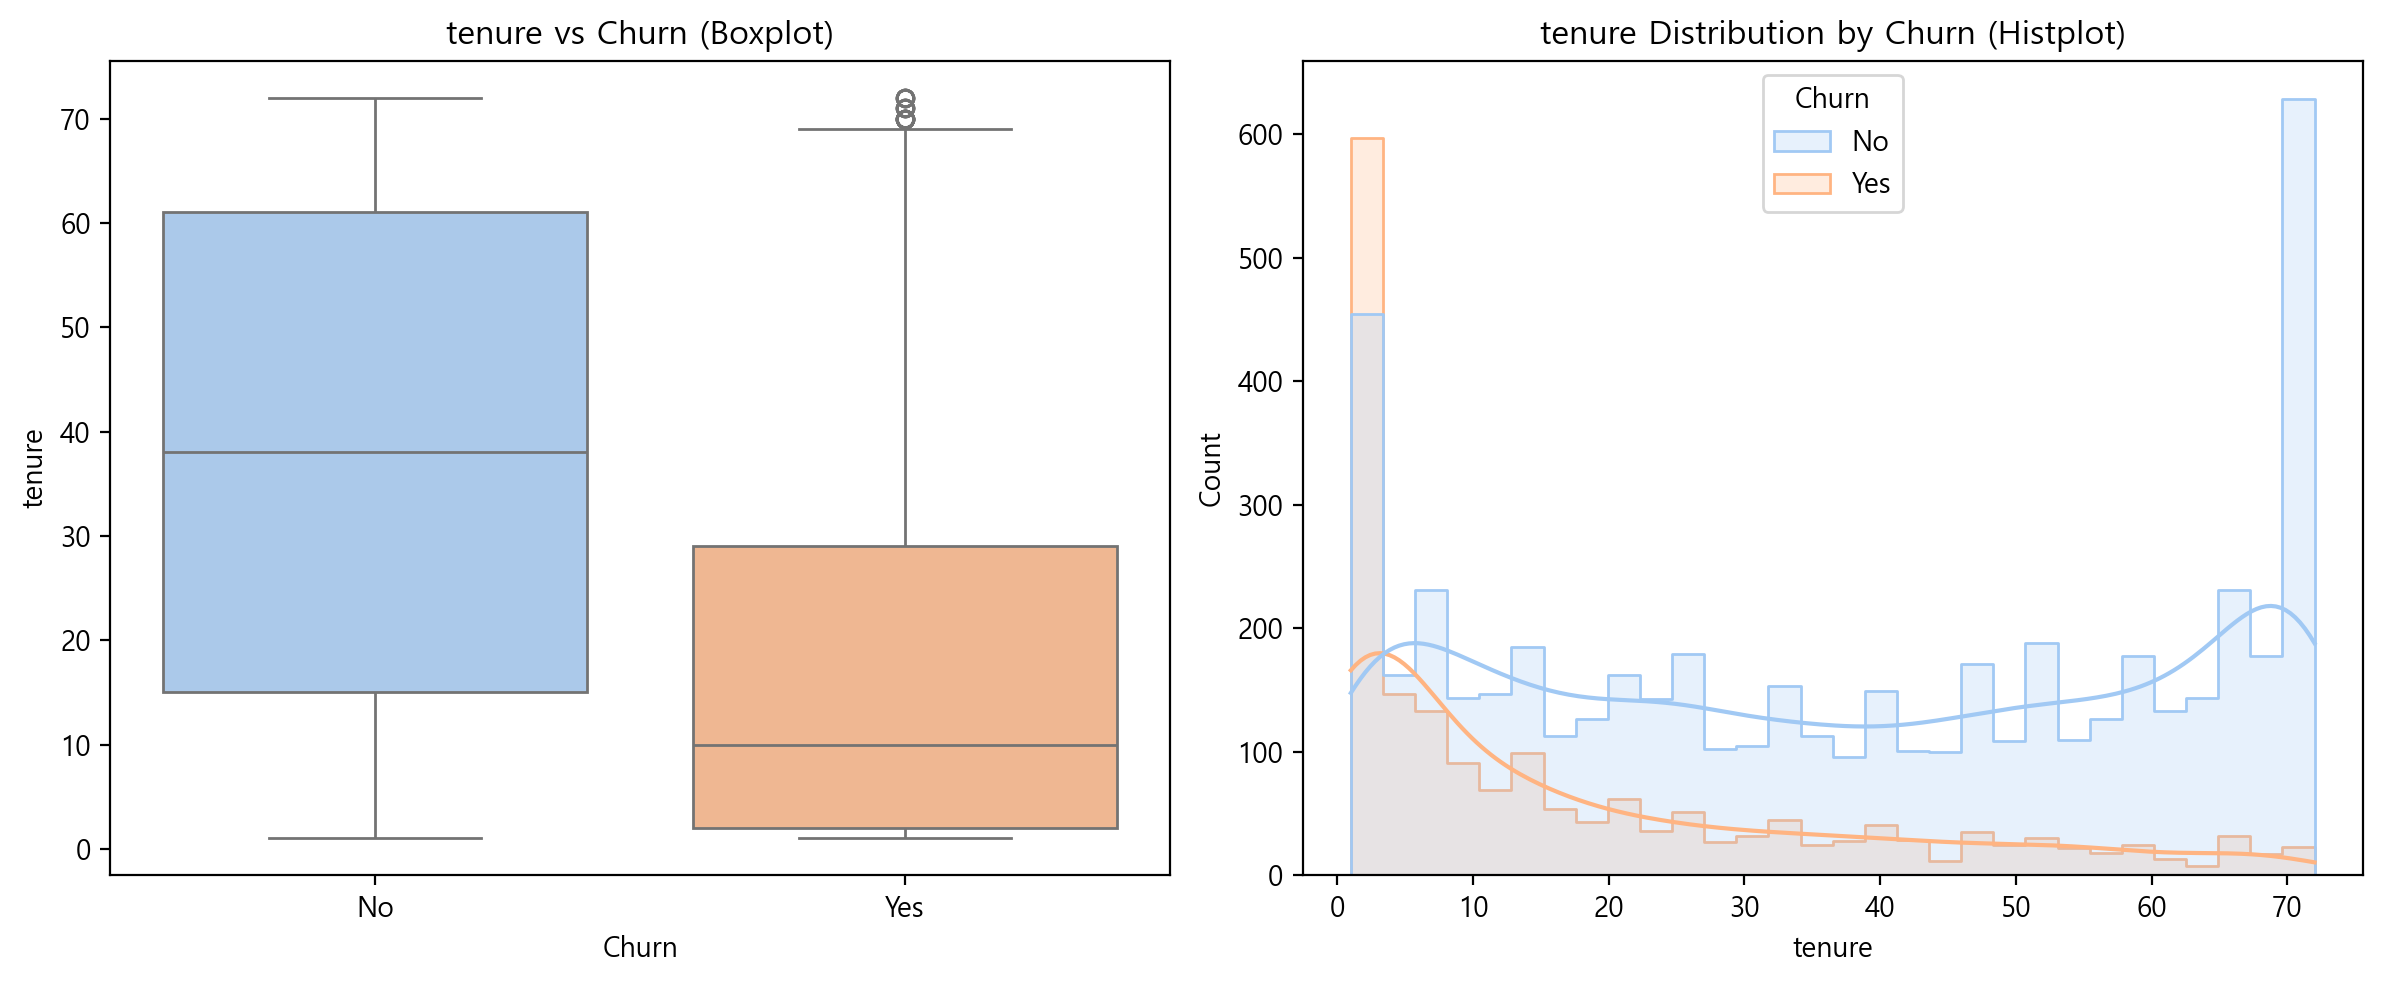

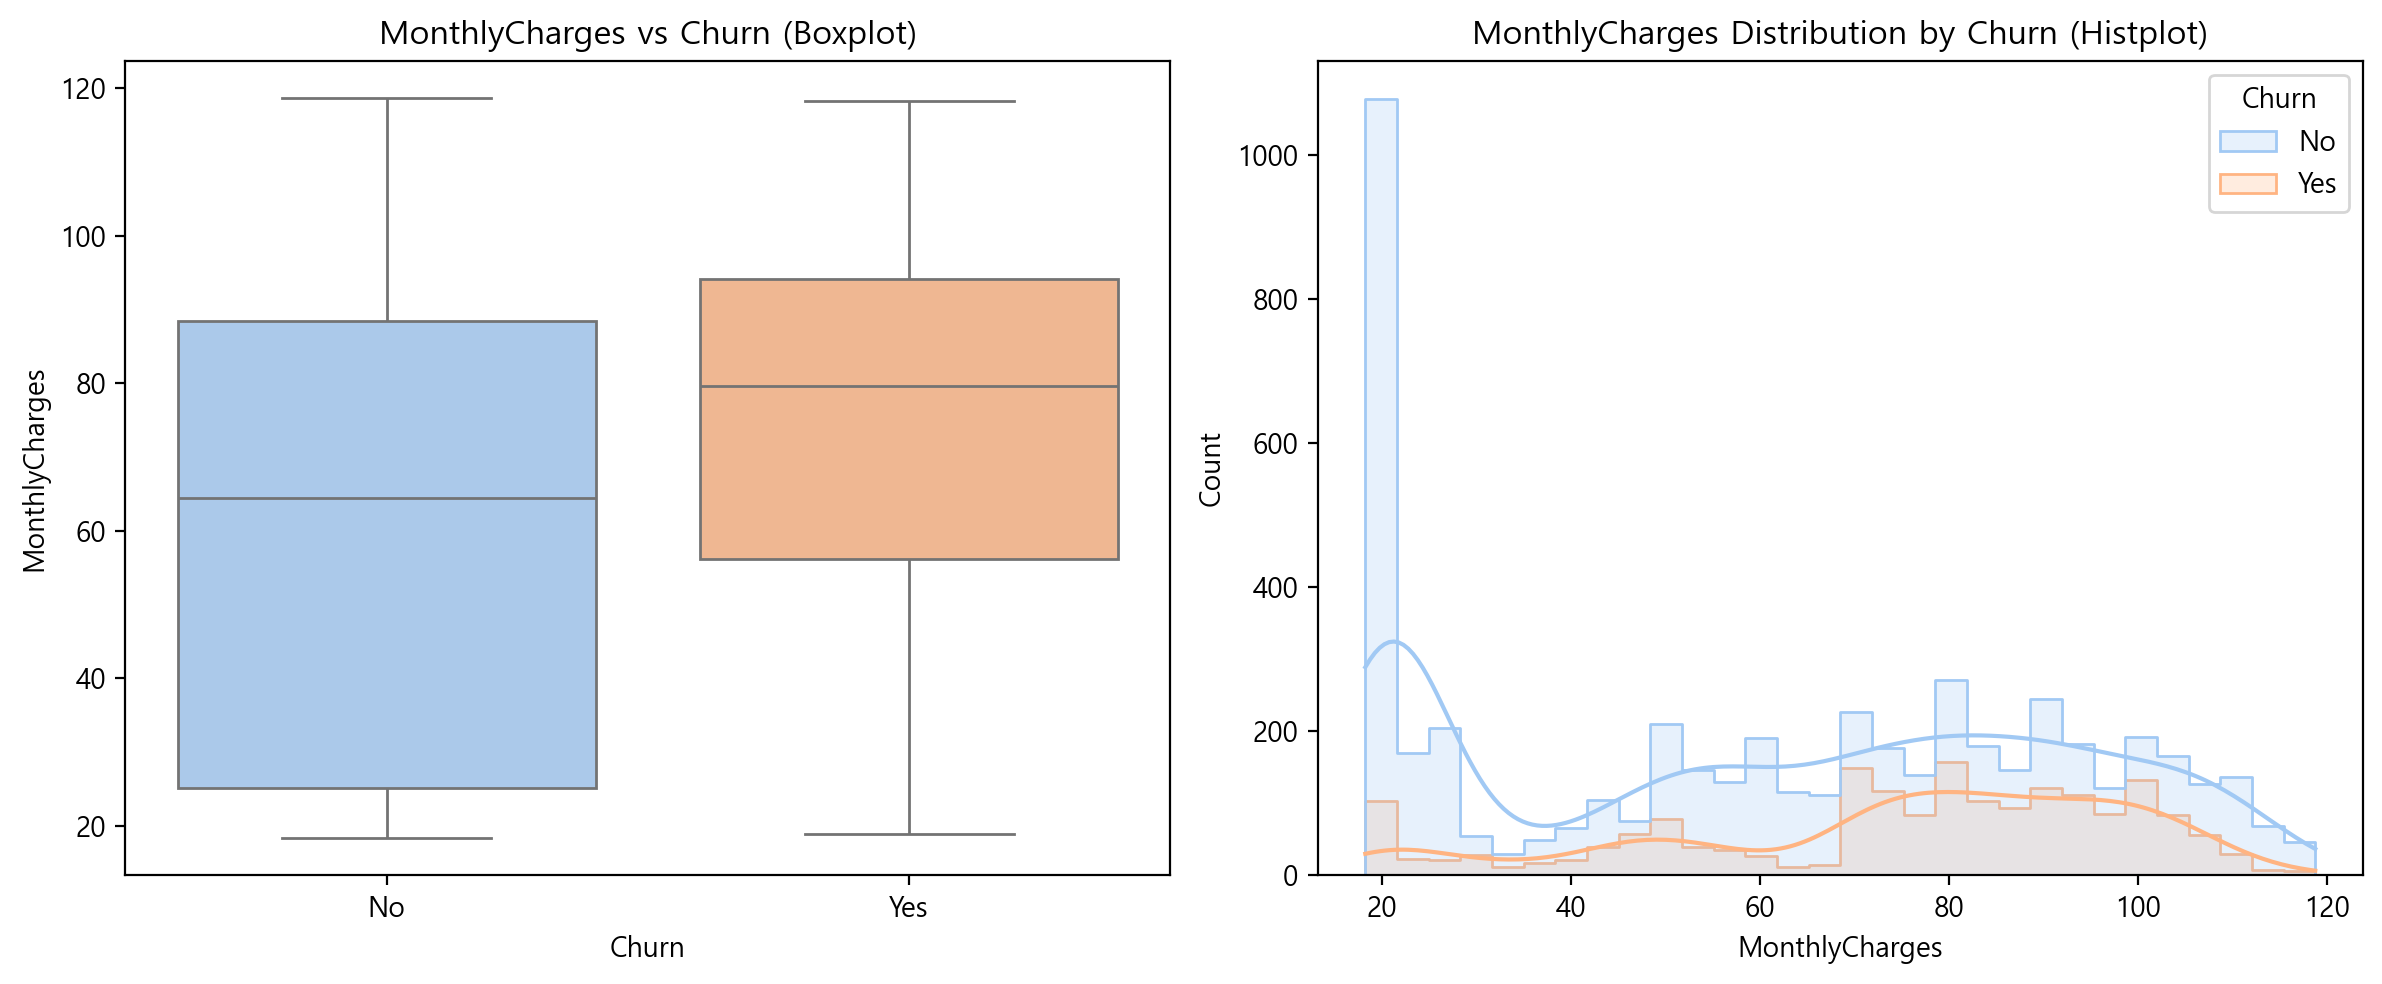

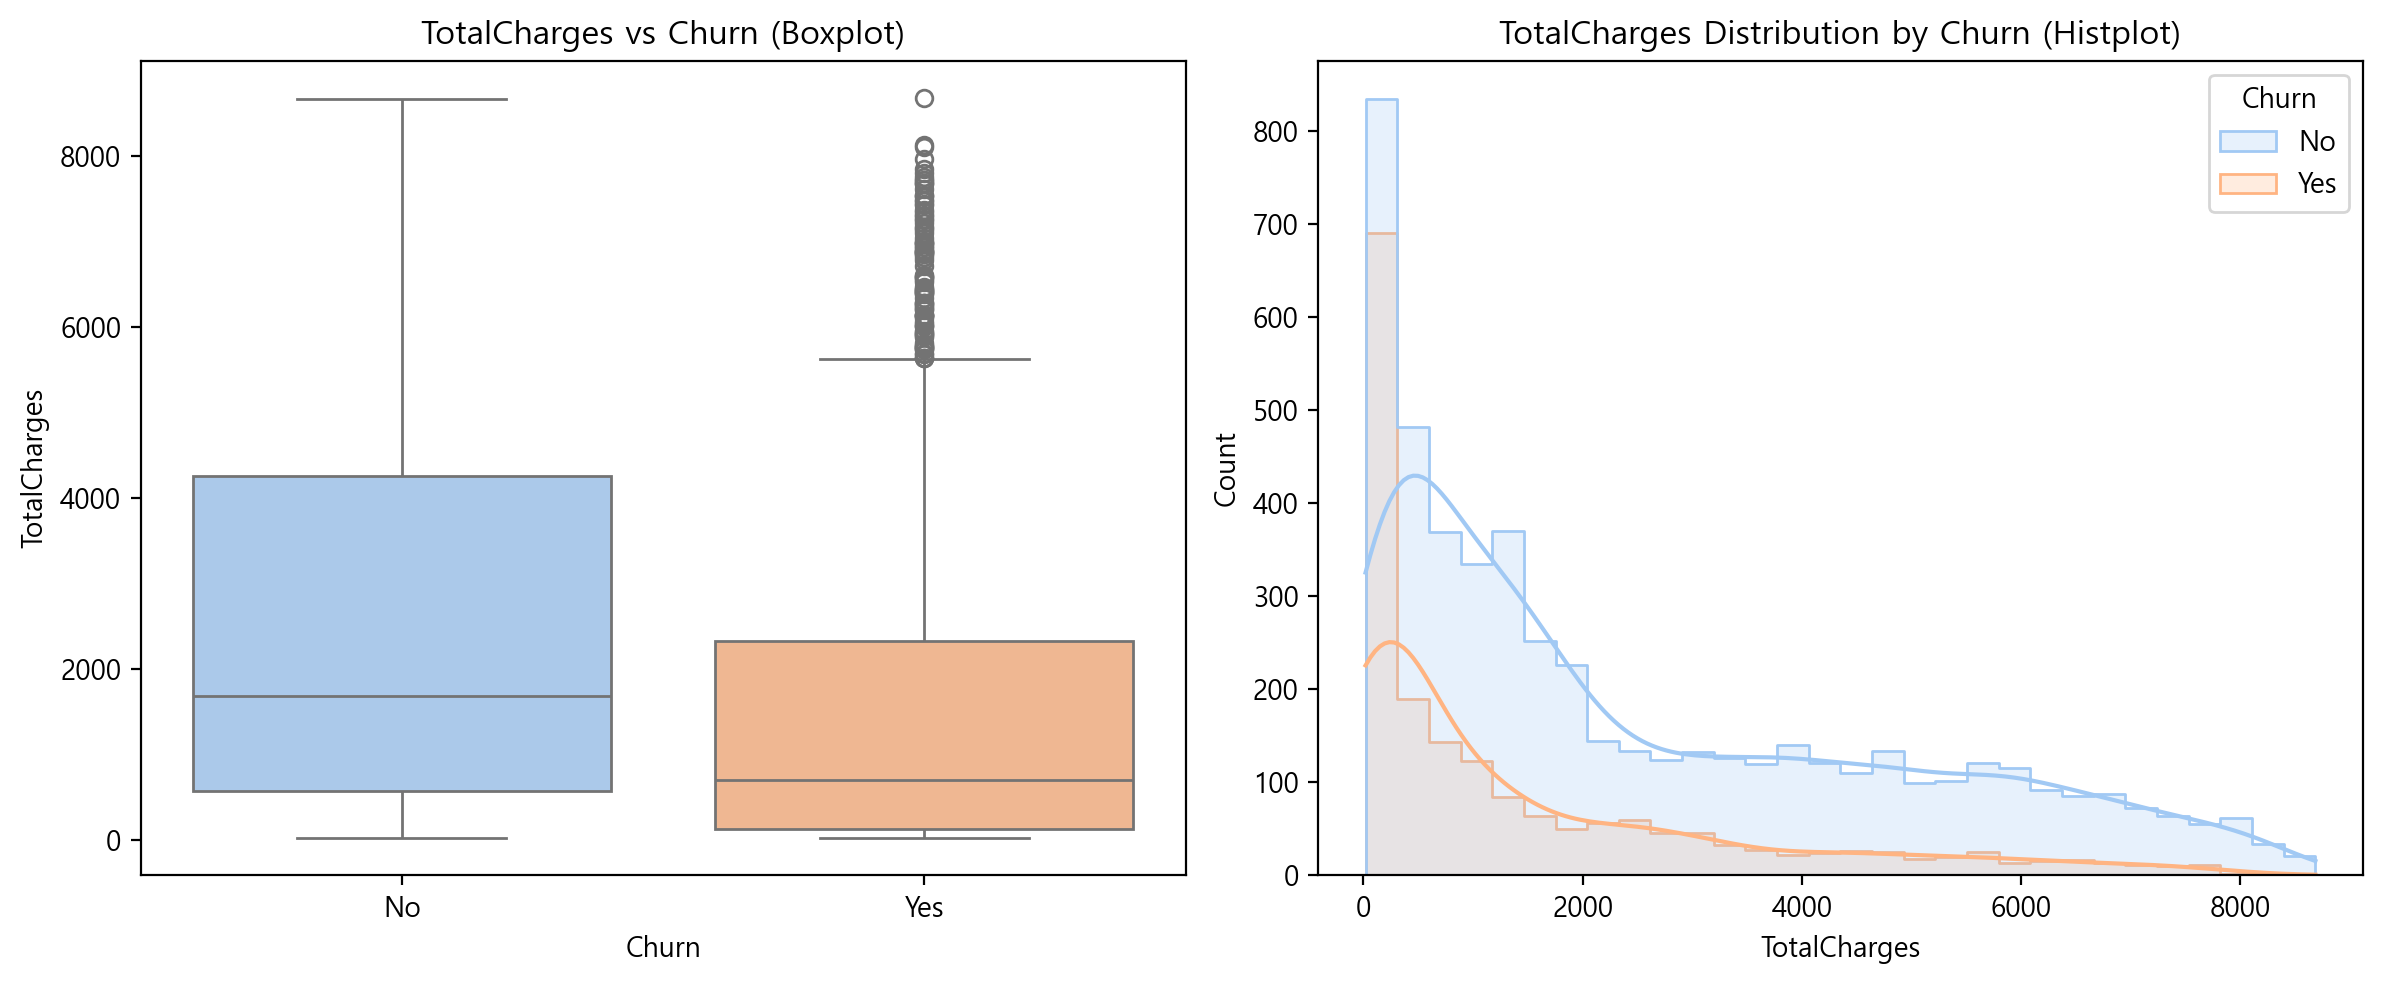

In [ ]:
# 3️⃣ 연속형 변수 vs Churn 관계 분석 (boxplot, histplot)

# 시각적으로 한눈에 비교할 수 있도록 컬럼별로 boxplot + histplot 생성

continuous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for feature in continuous_features:
    plt.figure(figsize=(12, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_clean, x='Churn', y=feature, palette='pastel')
    plt.title(f'{feature} vs Churn (Boxplot)')

    # Histplot
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_clean, x=feature, hue='Churn', kde=True, bins=30, palette='pastel', element='step')
    plt.title(f'{feature} Distribution by Churn (Histplot)')

    plt.tight_layout()
    plt.show()


### 설명:
- `tenure` (가입 기간)    
이탈 고객이 가입 기간이 짧은 경향이 뚜렷함 (가입 초기에 이탈 위험 높음)

- `MonthlyCharges` (월 요금)   
이탈 고객의 월 요금이 비이탈 고객보다 높은 편

- `TotalCharges` (누적 요금)   
이탈 고객의 누적 요금이 전체적으로 낮음 (가입 기간이 짧아 누적 요금이 낮은 것으로 해석 가능)

    ➡️ **"가입 기간이 짧고, 월 요금이 높으며, 누적 요금이 낮은”** 고객군이 이탈 위험군일 가능성이 높다

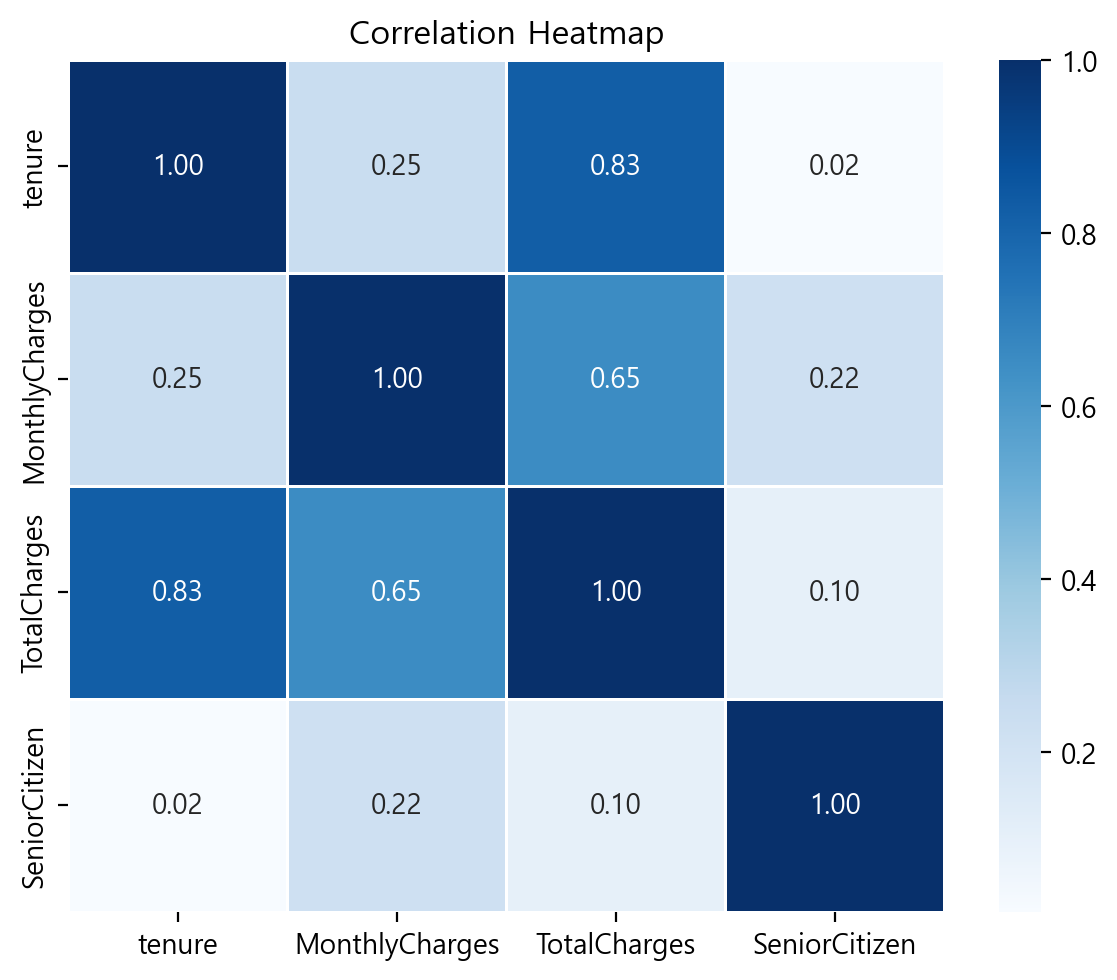

In [39]:
# Heatmap 




# Heatmap으로 변수 간 상관관계 확인
correlation_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
correlation_matrix = df_clean[correlation_features].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    linewidths=0.5,
    cbar=True
)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


### 설명:
- `tenure` ↔ `TotalCharges`: **0.83 (강한 양의 상관관계)**   
가입 기간이 길수록 누적 요금이 높아지는 것은 자연스러운 결과.

- `MonthlyCharges` ↔ `TotalCharges`: **0.65 (중간 정도의 양의 상관관계)**   
월 요금이 높을수록 누적 요금이 높지만, 가입 기간에 따라 차이가 나타날 수 있음.

- `SeniorCitizen`은 **다른 변수들과 상관관계가 약함**   
`MonthlyCharges`와 0.22 정도로 낮은 양의 상관관계가 있음


## 4️⃣ 범주형 변수 vs Churn 관계 분석 (countplot, barplot)
- `Contract`, `PaymentMethod`, `InternetService`, `gender`, `SeniorCitizen`, `Partner`, `Dependents` 등 주요 범주형 변수별로 이탈률 비교
- 이탈 위험 고객군의 범주형 특성 파악 ➡️ 전략 기획 기반을 강화하기

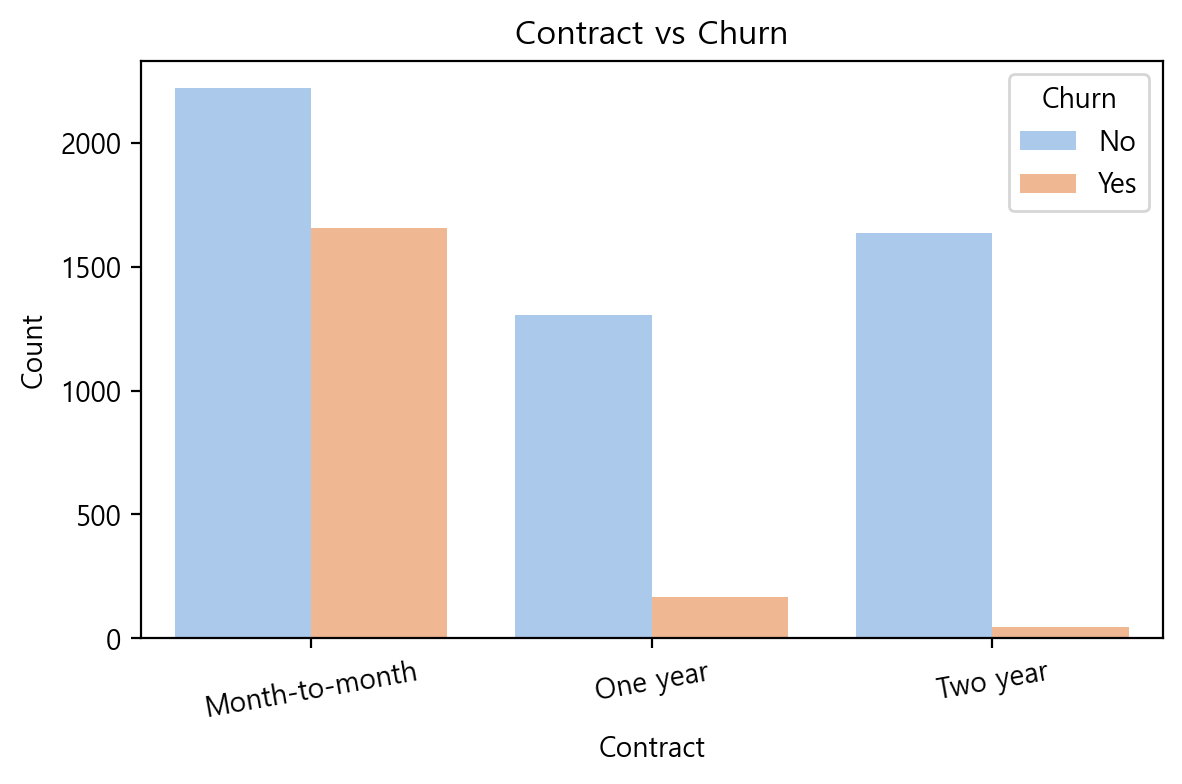

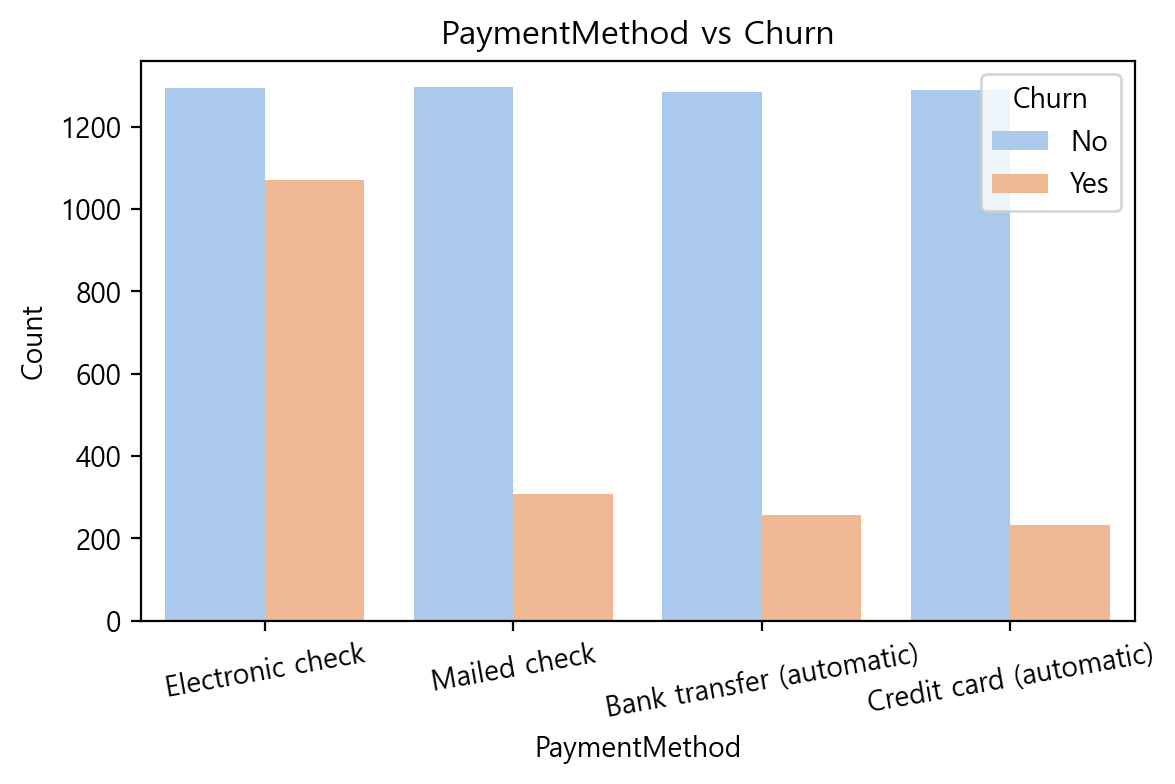

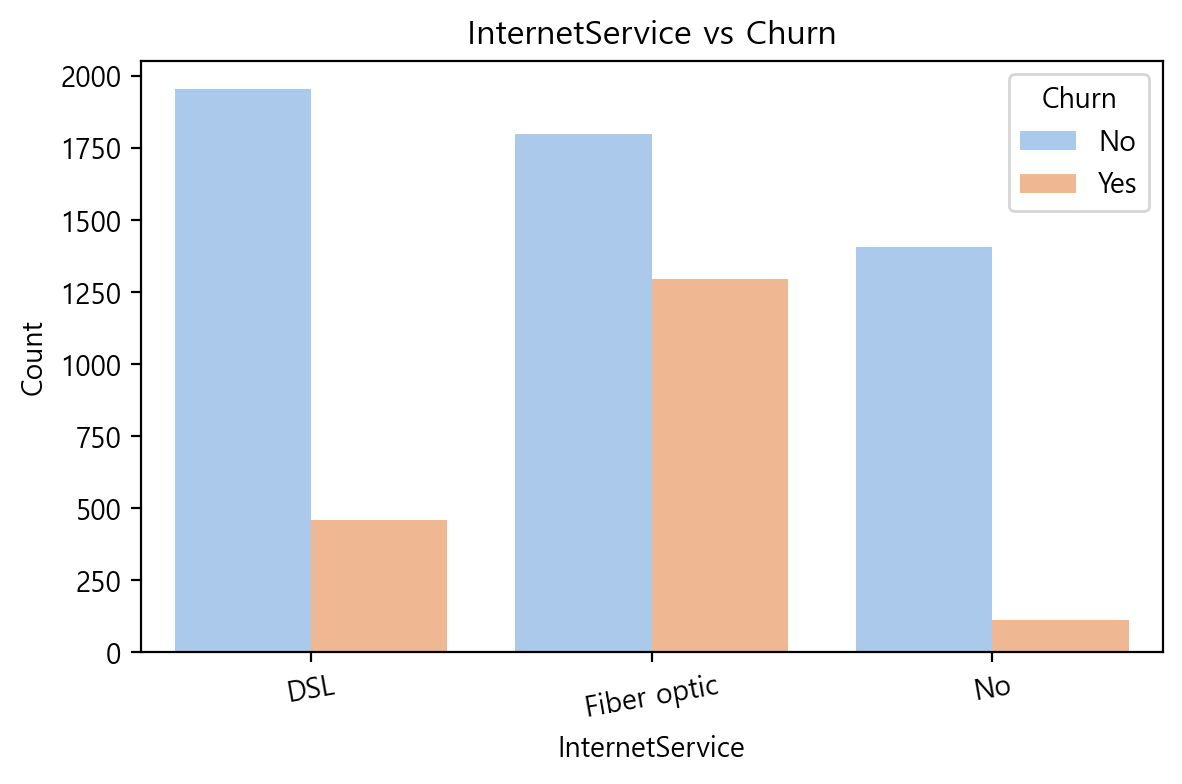

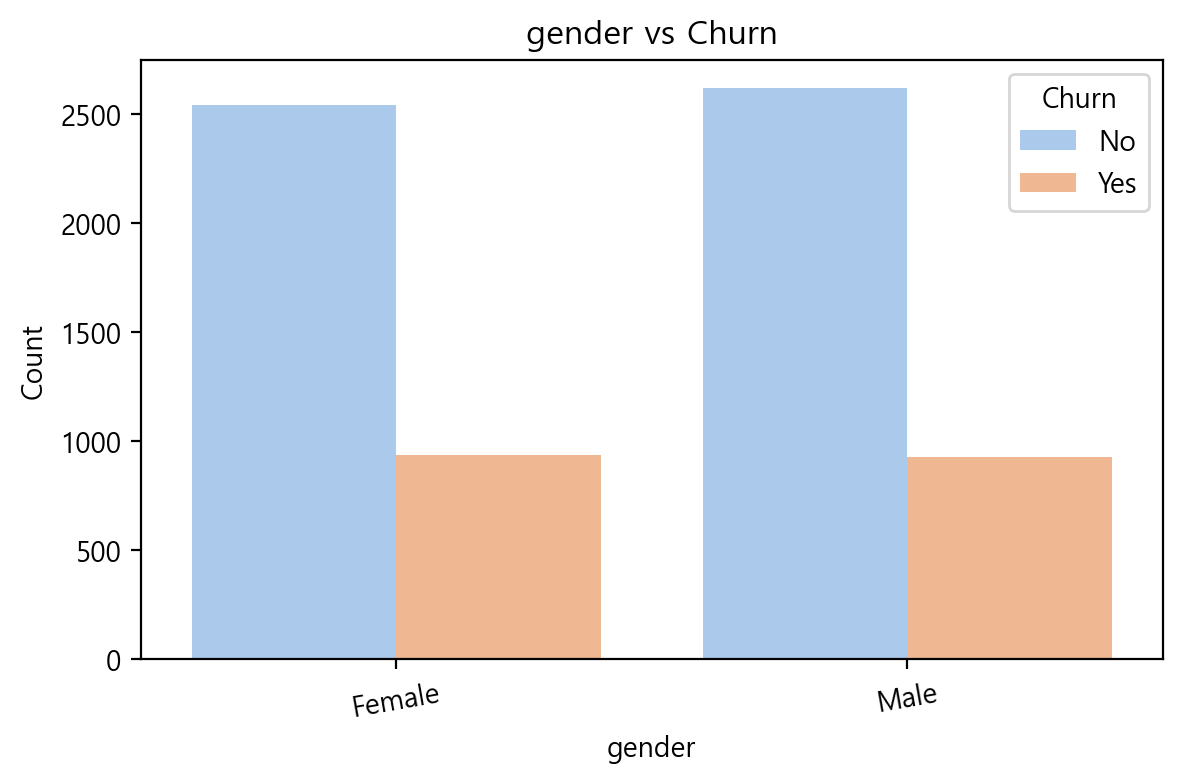

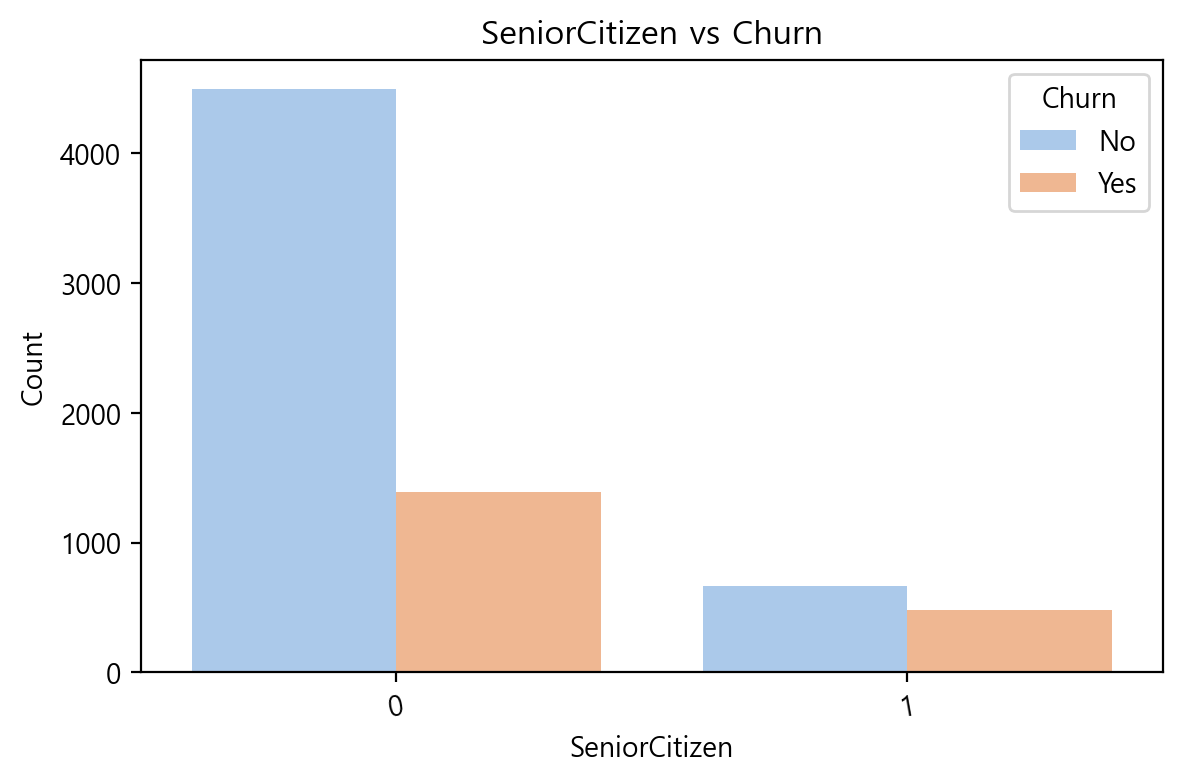

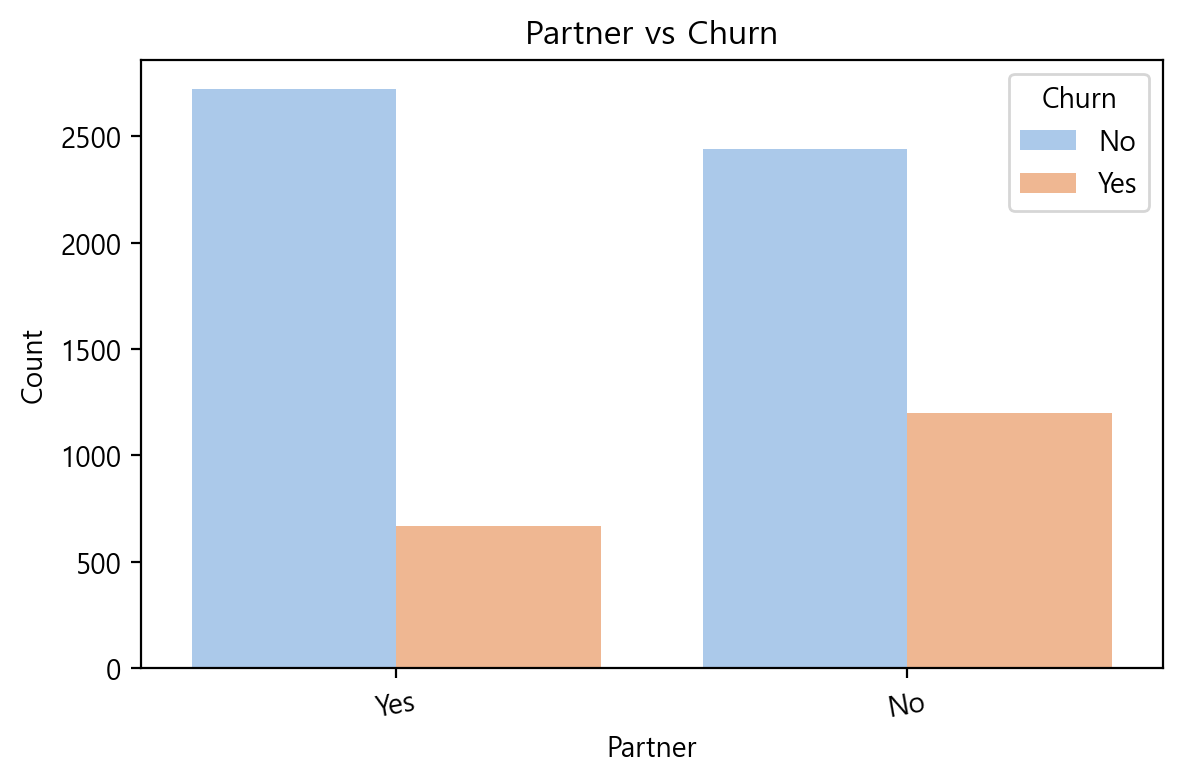

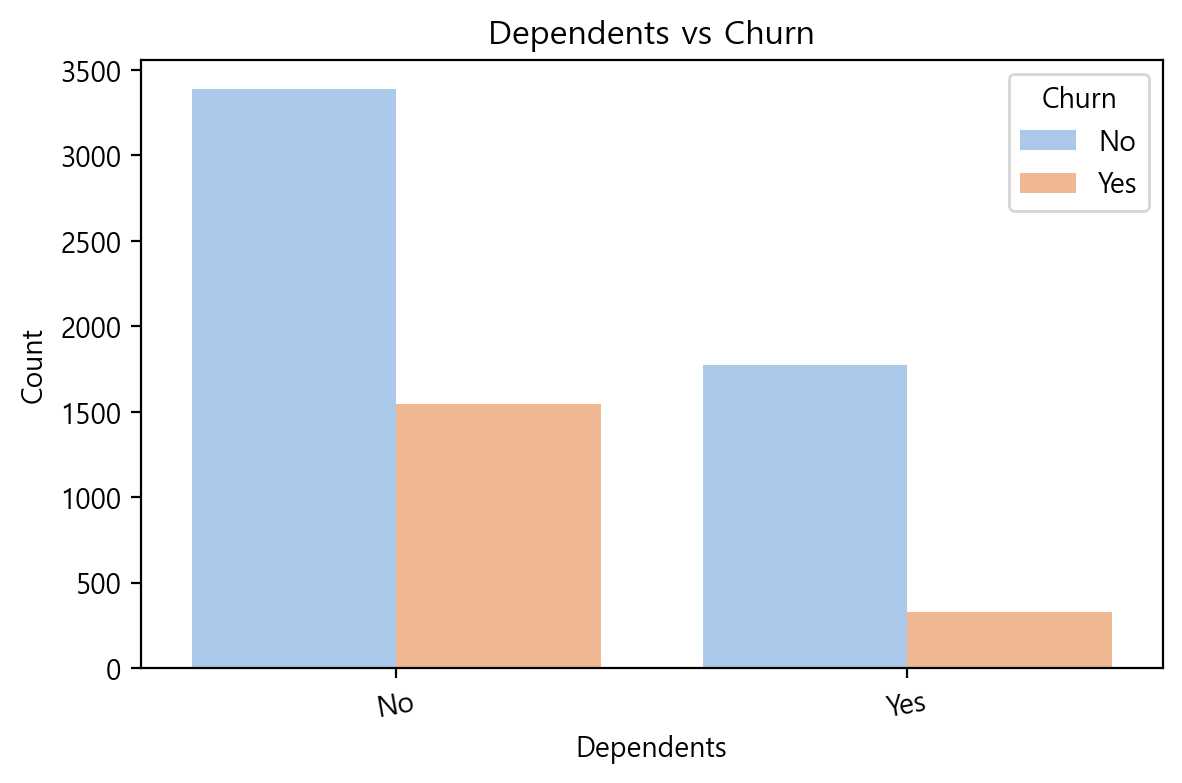

In [25]:
# 4️⃣ 범주형 변수 vs Churn 관계 분석 (countplot, barplot)

categorical_features = ['Contract', 'PaymentMethod', 'InternetService', 'gender', 
                        'SeniorCitizen', 'Partner', 'Dependents']

# 컬럼별로 이탈 여부별 countplot 시각화
for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_clean, x=feature, hue='Churn', palette='pastel')
    plt.title(f'{feature} vs Churn')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=10)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()


### 설명:
`Contract`:
`Month-to-month` 계약에서 이탈률이 높음,
`One year`, `Two year` 계약은 이탈률이 낮음.

`PaymentMethod`:
`Electronic check` 결제 방식의 이탈률이 유난히 높음.

`InternetService`:
`Fiber optic` 사용자가 이탈률이 더 높음.

`gender`:
남녀 간 이탈률은 크게 차이가 없음.

`SeniorCitizen`:
시니어 고객(1)의 이탈률이 더 높음.

`Partner`, `Dependents`:
`Partner`가 없고 `Dependents`가 없는 고객의 이탈률이 더 높음.


## 5️⃣ 위험 고객군 조건 정의 및 필터링
- 위 분석을 바탕으로 이탈 위험 고객군 조건을 정의하여 실제 고객을 추출   
- 유치 전략(맞춤 혜택, 전환 유도 프로모션) 기획용 테이블로 활용

In [26]:
# 5️⃣ 위험 고객군 조건 정의 및 필터링

# 위 분석을 기반으로 조건 정의:
# - 계약 형태: Month-to-month
# - 결제 방식: Electronic check
# - 가입 기간: tenure <= 6개월
# - 월 요금: 평균 이상

# 평균 월 요금 확인
monthly_charges_mean = df_clean['MonthlyCharges'].mean()

# 조건 필터링
churn_risk_group = df_clean[
    (df_clean['Contract'] == 'Month-to-month') &
    (df_clean['PaymentMethod'] == 'Electronic check') &
    (df_clean['tenure'] <= 6) &
    (df_clean['MonthlyCharges'] >= monthly_charges_mean)
]

# 추출된 이탈 위험 고객군의 규모 확인
print(f"이탈 위험 고객군 추출 완료: {len(churn_risk_group)}명 식별")

# 추출된 데이터 5행 미리보기
churn_risk_group.head()




이탈 위험 고객군 추출 완료: 450명 식별


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
36,6047-YHPVI,Male,0,No,No,5,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,69.70,316.90,Yes
47,7760-OYPDY,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.65,144.15,Yes
65,5122-CYFXA,Female,0,No,No,3,Yes,No,DSL,No,...,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,75.30,244.10,No
80,5919-TMRGD,Female,0,No,Yes,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.35,79.35,Yes


## 6️⃣  이탈 위험 고객군(450명) 기반으로 구체화한 고객 유치 전략

### 1) 핵심 문제 인식
- 450명은 가입 6개월 이하, 월 요금 높음, 단기 계약, 전자 결제 방식 사용 ➡️ 이탈 위험이 높음.   
- 이탈 고객 중 많은 수가 요금이 높은 상태에서 장기 사용을 하지 않고 해지하는 패턴   
- 이탈 비용(고객 획득 비용)이 신규 고객 유치 비용보다 낮은 경우 적극적으로 유지 필요


### 2) 고객 유치 전략 목표
- 이탈 방지 및 고객 Lifetime Value(LTV) 향상   
- 장기 계약 전환 유도   
- 만족도 향상 → 긍정 구전 → 신규 유입 간접 유치 효과


### 3) 구체 전략
 (1) 요금제 및 혜택 기반 유치 
- 장기 계약 전환 시 월 요금 5~10% 할인 프로모션 제공
- `Month-to-month` ➡️ `1 year` 또는 `2 year`로 전환 시 포인트/상품권 제공
- 데이터 사용량 기반 혜택 패키지 제공(OTT 무료 제공, 추가 데이터)

 (2) 결제 방식 개선 유도
- Electronic check ➡️ 자동 이체/카드 결제 전환 시 첫 달 요금 할인 제공   
- 자동 결제 전환 고객 대상 추첨 이벤트 진행

 (3) 맞춤 커뮤니케이션
- 가입 3~6개월 고객 대상 해지 가능성이 높으므로 가입 2개월차부터 혜택/장기 전환 제안 메시지 발송   
- Fiber optic 사용 고객에 대해 서비스 품질 개선 및 속도 업그레이드 프로모션 안내

 (4) 이탈 사유 사전 파악 및 대응
- 과금 불만, 서비스 품질 불만 조사 설문 발송 및 응답 고객에게 혜택 제공   
- 고객센터/챗봇 통해 문의 및 불만 접수 시 우선 대응 ➡️ 해지 접점 차단



### 4) 구체 실행 예시

| 실행 항목           | 구체 내용                           | KPI        |
| --------------- | ------------------------------- | ---------- |
| **장기 계약 전환 할인** | 1년 계약 시 월 5% 할인, 2년 계약 시 10% 할인 | 전환율 15%    |
| **결제 방식 전환 혜택** | 자동 이체 전환 시 1개월 요금 50% 할인        | 전환율 20%    |
| **데이터 혜택 패키지**  | 3개월 이상 사용 고객 OTT 1개월 무료         | 이탈률 5% 감소  |
| **만족도 설문 및 혜택** | 설문 참여 시 커피 쿠폰 제공                | 응답률 30%    |
| **이탈 예측 알림**    | 가입 2개월차 고객 대상 혜택 메시지            | 혜택 사용률 40% |



### 5) 데이터 기반 시뮬레이션
- 450명 고객이 10%만 장기 전환 시 45명 유지   
- 1명당 LTV가 $400 증가하면 $18,000 수익 상승 효과 발생 가능


## 7️⃣ 결론
### 1) **고위험 고객군**   

(1) 단기 계약과 전자결제를 사용하고 있어 언제든지 계약 해지 가능     
(2) 가입 시기가 짧아 이탈 확률이 높음   
(3) 매달 요금이 높음


### 2) **고객 유치 전략**   

(1) 장기 계약 전환 유도   
- 1~2년 장기 계약 전환 시 요금 할인, 포인트/혜택 제공으로 해지 장벽을 높이고, 안정적인 수익 확보

(2) 자동 결제 전환 유도   
- 전자결제 사용 고객에게 자동이체/카드 결제 전환 시 혜택 제공 ➡️ 해지 시도 단계에서 이탈 방지

(3) 맞춤 혜택 제공   
- 가입 2~3개월 시점부터 혜택 메시지 발송   
- OTT 무료 이용권, 데이터 추가 제공 등 혜택으로 해지 유인 완화

(4) 고객 만족도 및 불만 해소
- 만족도 조사 및 불만 사전 파악 ➡️ 해지 전 불만 해소 및 혜택 제공으로 이탈 방지


### 3) 기대 효과   

- 고위험 고객군의 이탈을 방지    
- 고객 생애 가치(LTV)를 높임    
- 회사의 지속적인 수익 기반을 강화